In [4]:
!pip install transformers
!pip install torch

  Using cached sympy-1.12.1-py3-none-any.whl.metadata (12 kB)
  Using cached mkl-2021.4.0-py2.py3-none-win_amd64.whl.metadata (1.4 kB)
  Using cached intel_openmp-2021.4.0-py2.py3-none-win_amd64.whl.metadata (1.2 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/159.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/159.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/159.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/159.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/159.8 MB 131.3 kB/s eta 0:20:17
   ---------------------------------------- 0.0/159.8 MB 131.3 kB/s eta 0:20:17
   ---------------------------------------- 0.0/159.8 MB 131.3 kB/s eta 0:20:17
   ---------------------------------------- 0.1/159.8 MB 163.6 kB/s eta 0:16:17
   ---------------------------------------- 0.1/159.8 MB 187.3 kB/s eta 0:14:13
   ---------------------------------

In [13]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [5]:
import json
from detection.data_loader import DataLoader
from detection.utils import JAEGER_LOG_PATH_WITH_ERROR

dl = DataLoader(JAEGER_LOG_PATH_WITH_ERROR)
traces = dl.get_traces()
# processes = dl.get_processes()
# print()
# Extract relevant textual data
texts = []
for trace in traces:
    for span in trace['spans']:
        operation_name = span.get('operationName', '')
        service_name = trace.get('processes', {}).get(f"{span.get('processID', '')}", '').get('serviceName', '')

        log_messages = []
        for log in span.get('logs', []):
            for field in log.get('fields', []):
                if field['key'] == 'exception.message' or field['key'] == 'exception.stacktrace' or field['key'] == 'exception.type':
                    log_messages.append(field['value'])

        # Combine extracted fields into a single string
        combined_text = f"Operation: {operation_name}, Service: {service_name}, Exception: {'; '.join(log_messages)}"
        texts.append(combined_text)

print("Extracted texts:", texts)

Extracted texts: ['Operation: POST /api/cats/pairs, Service: cat-api, Exception: ', 'Operation: CatController.generatePairs, Service: cat-api, Exception: Oops, bad number; org.jetbrains.service.CatRecommenderIntegrationException: Oops, bad number\n\tat org.jetbrains.service.CatService.suggestCat(CatService.kt:63)\n\tat org.jetbrains.service.CatService.generatePairs(CatService.kt:39)\n\tat java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)\n\tat java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)\n\tat java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)\n\tat java.base/java.lang.reflect.Method.invoke(Unknown Source)\n\tat org.springframework.aop.support.AopUtils.invokeJoinpointUsingReflection(AopUtils.java:343)\n\tat org.springframework.aop.framework.CglibAopProxy$DynamicAdvisedInterceptor.intercept(CglibAopProxy.java:698)\n\tat org.jetbrains.service.CatService$$SpringCGLIB$$0.generatePairs(<generated>

In [8]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

H:\Documents\Apply\Applications\TU Delft\Assessment\test-assignment\venv\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Asus\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [9]:

inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")


In [10]:
with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Average pooling


In [14]:
# Standardize the embeddings
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings.numpy())

# Fit the Isolation Forest model
iso_forest = IsolationForest(contamination=0.1)
iso_forest.fit(embeddings_scaled)

# Predict anomalies
predictions = iso_forest.predict(embeddings_scaled)
anomalies = predictions == -1


In [15]:
for i, text in enumerate(texts):
    print(f"Text: {text}")
    print(f"Anomaly: {'Yes' if anomalies[i] else 'No'}")
    print()


Text: Operation: POST /api/cats/pairs, Service: cat-api, Exception: 
Anomaly: No

Text: Operation: CatController.generatePairs, Service: cat-api, Exception: Oops, bad number; org.jetbrains.service.CatRecommenderIntegrationException: Oops, bad number
	at org.jetbrains.service.CatService.suggestCat(CatService.kt:63)
	at org.jetbrains.service.CatService.generatePairs(CatService.kt:39)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.base/java.lang.reflect.Method.invoke(Unknown Source)
	at org.springframework.aop.support.AopUtils.invokeJoinpointUsingReflection(AopUtils.java:343)
	at org.springframework.aop.framework.CglibAopProxy$DynamicAdvisedInterceptor.intercept(CglibAopProxy.java:698)
	at org.jetbrains.service.CatService$$SpringCGLIB$$0.generatePairs(<generated>)
	at org.jetbr

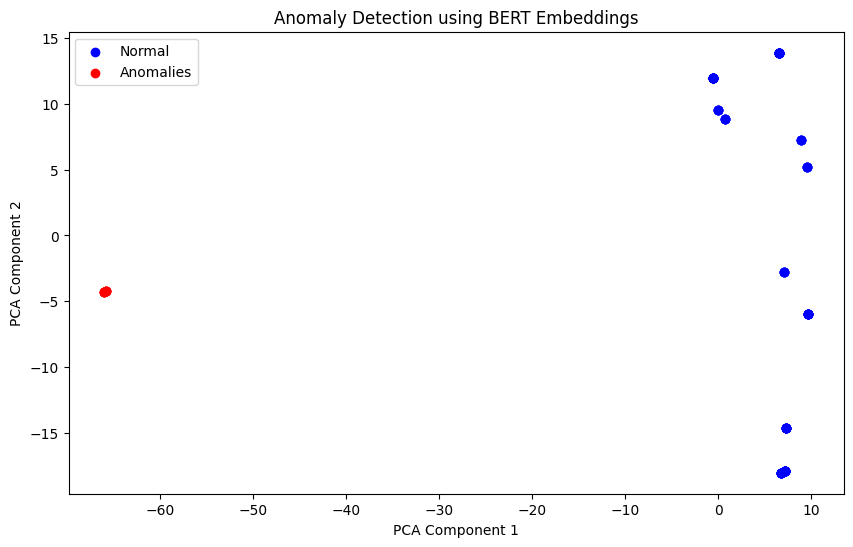

In [16]:
# Reduce dimensions for plotting using PCA

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_scaled)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[~anomalies, 0], embeddings_2d[~anomalies, 1], c='blue', label='Normal')
plt.scatter(embeddings_2d[anomalies, 0], embeddings_2d[anomalies, 1], c='red', label='Anomalies')
plt.title('Anomaly Detection using BERT Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()